In [2]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


## Problem 1

In [13]:
dir_name = "./notMNIST_small/A/"
file_names = [o.name for o in os.scandir(dir_name) if o.is_file()]
for file_name in file_names[:5]:
    display(Image(dir_name + file_name))
    print(file_name)
    

SHVtbnN0Nzc3IEJsa0NuIEJUIEJsYWNrLnR0Zg==.png


SGFuZHdlcmsudHRm.png


RW5ncmF2ZXItTGlnaHQgRXggQm9sZCBJdGFsaWMudHRm.png


QnJpZGdld29ya0EudHRm.png


QWFiY2VkIFJlZ3VsYXIudHRm.png


In [19]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825014
Standard deviation: 0.44312122
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0075630327
Standard deviation: 0.4544914
Pickling ./notMNIST_large/C.pickle.
./notMNIST_large/C
Full dataset tensor: (52912, 2

## Problem 2



In [31]:
with open('./notMNIST_small/A.pickle', 'rb') as f:
    test_dataset_deserise_a = pickle.load(f)

In [22]:
train_dataset_deserise_a[1]

array([[-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.49215686, -0.5       ,
        -0.38235295,  0.4490196 ,  0.5       ,  0.49607843,  0.5       ,
         0.4882353 ,  0.5       , -0.05294118, -0.5       , -0.48431373,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.48431373, -0.5       ,
        -0.04117647,  0.5       ,  0.4882353 ,  0.5       ,  0.5       ,
         0.4882353 ,  0.5       ,  0.28431374, -0.48431373, -0.5       ,
        -0.49607843, -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.49607843, -0.5       , -0.46862745,
         0.31176472,  0.5   

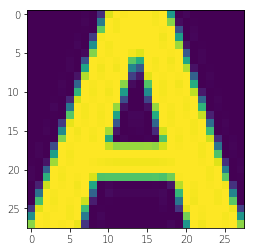

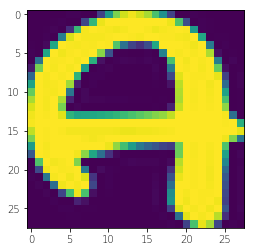

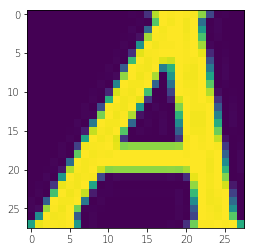

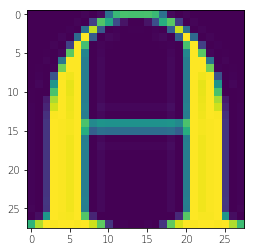

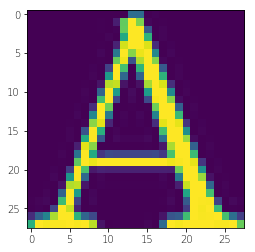

In [37]:
for i in range(5):
    plt.imshow(test_dataset_deserise_a[i])
    plt.show()

## Problem 3

In [39]:

pickle_file_names = [o.name for o in os.scandir('./notMNIST_large') if o.is_file()]
print(pickle_file_names)

['A.pickle', 'B.pickle', 'C.pickle', 'D.pickle', 'E.pickle', 'F.pickle', 'G.pickle', 'H.pickle', 'I.pickle', 'J.pickle']


In [47]:
test_dataset_dic = {}
for pickle_file_name in pickle_file_names:
    with open('./notMNIST_small/' + pickle_file_name, 'rb') as f:
        test_dataset_dic[pickle_file_name.strip('.pickle')]= pickle.load(f)

In [49]:
for letter,letter_test_dataset in test_dataset_dic.items():
    print(letter + ':' + str(len(letter_test_dataset)))

A:1872
B:1873
C:1873
D:1873
E:1873
F:1872
G:1872
H:1872
I:1872
J:1872


In [52]:
train_dataset_dic = {}
for pickle_file_name in pickle_file_names:
    with open('./notMNIST_large/' + pickle_file_name, 'rb') as f:
        train_dataset_dic[pickle_file_name.strip('.pickle')]= pickle.load(f)

In [53]:
for letter,letter_train_dataset in train_dataset_dic.items():
    print(letter + ':' + str(len(letter_train_dataset)))

A:52909
B:52911
C:52912
D:52911
E:52912
F:52912
G:52912
H:52912
I:52912
J:52911


In [54]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [55]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4


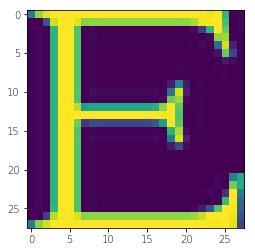

4


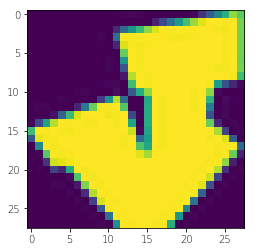

9


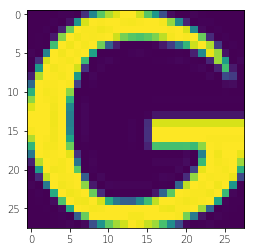

6


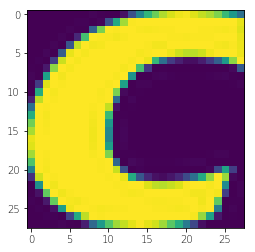

2


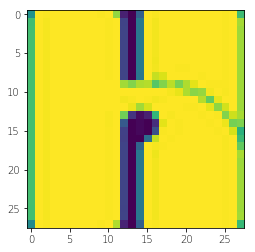

7


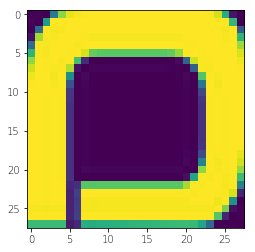

3


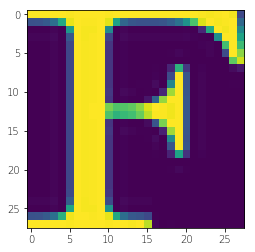

5


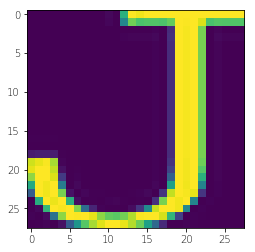

9


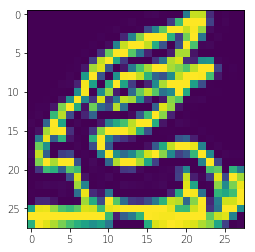

6


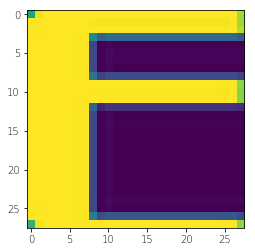

4


In [57]:
for i in range(10):
    plt.imshow(train_dataset[i])
    plt.show()
    print(train_labels[i])


In [58]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [59]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Problem 5

In [3]:
with open('./notMNIST.pickle','rb') as f:
    ds = pickle.load(f)

In [8]:
ds['train_dataset'][0] == ds['valid_dataset'][0]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False,  True, False, False, False,
        False

In [9]:
train_valid_overlap = []
train_test_overlap = []
for i in range(len(ds['train_dataset'])):
    for j in range(len(ds['valid_dataset'])):
        if(ds['train_dataset'][i] == ds['valid_dataset'][j]).all():
            train_valid_overlap.append((i,j))
    for k in range(len(ds['valid_dataset'])):
        if(ds['train_dataset'][i] == ds['test_dataset'][k]).all():
            train_test_overlap.append((i,k))


KeyboardInterrupt: 

In [ ]:
train_valid_overlap

In [ ]:
train_test_overlap

In [10]:
valid_test_overlap = []
for i in range(len(ds['valid_dataset'])):
    for j in range(len(ds['test_dataset'])):
        if(ds['valid_dataset'][i] == ds['test_dataset'][j]).all():
            valid_test_overlap.append((i,j))
valid_test_overlap

[(3, 307),
 (3, 354),
 (3, 445),
 (3, 517),
 (3, 538),
 (3, 672),
 (3, 714),
 (3, 783),
 (3, 849),
 (3, 1116),
 (3, 1186),
 (3, 1295),
 (3, 1382),
 (3, 1451),
 (3, 1731),
 (3, 1732),
 (3, 1751),
 (3, 1807),
 (3, 1921),
 (3, 1941),
 (3, 1950),
 (3, 2135),
 (3, 2247),
 (3, 2248),
 (3, 2386),
 (3, 2404),
 (3, 2524),
 (3, 2541),
 (3, 2567),
 (3, 2650),
 (3, 2746),
 (3, 2914),
 (3, 3004),
 (3, 3047),
 (3, 3104),
 (3, 3187),
 (3, 3314),
 (3, 3489),
 (3, 3499),
 (3, 3503),
 (3, 3832),
 (3, 3860),
 (3, 4077),
 (3, 4095),
 (3, 4209),
 (3, 4211),
 (3, 4232),
 (3, 4266),
 (3, 4282),
 (3, 4288),
 (3, 4394),
 (3, 4427),
 (3, 4493),
 (3, 4494),
 (3, 4528),
 (3, 4592),
 (3, 4737),
 (3, 4760),
 (3, 4784),
 (3, 5248),
 (3, 5258),
 (3, 5309),
 (3, 5515),
 (3, 5543),
 (3, 5590),
 (3, 5635),
 (3, 5719),
 (3, 5852),
 (3, 5868),
 (3, 5937),
 (3, 5951),
 (3, 6021),
 (3, 6062),
 (3, 6088),
 (3, 6094),
 (3, 6161),
 (3, 6317),
 (3, 6590),
 (3, 6617),
 (3, 6647),
 (3, 6727),
 (3, 6805),
 (3, 7029),
 (3, 7036),
 

In [11]:
ds['test_dataset'][4282] == ds['test_dataset'][4266]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True

In [12]:
len(valid_test_overlap)

13391

What about near duplicates between datasets? (images that are almost identical)
准确率会很高，但泛化能力差。对新数据的预测效果不一定好


In [33]:
def unique(input_data):
    test_dataset_copy = input_data.copy().tolist()
    clean_dataset = []
    current_data = test_dataset_copy.pop()
    while current_data:
        exist = False
        for clean_data in clean_dataset:
            if(clean_data == current_data):
                exist = True
                break
        if(not exist):
            clean_dataset.append(current_data.copy())
        if(len(test_dataset_copy) > 0):
            current_data = test_dataset_copy.pop()
        else:
            current_data = None
    return clean_dataset
            
clean_test_dataset = unique(ds['test_dataset'])

In [34]:
len(clean_test_dataset)

9802

In [35]:
clean_valid_dataset = unique(ds['valid_dataset'])

In [36]:
len(clean_valid_dataset)

9850

In [38]:
clean_valid_test_overlap = []
for i in range(len(clean_valid_dataset)):
    for j in range(len(clean_test_dataset)):
        if(clean_valid_dataset[i] == clean_test_dataset[j]):
            clean_valid_test_overlap.append((i,j))
clean_valid_test_overlap

[(0, 634),
 (64, 86),
 (122, 9434),
 (184, 5925),
 (280, 6725),
 (293, 6656),
 (393, 6896),
 (688, 8228),
 (854, 280),
 (1043, 2470),
 (1110, 3823),
 (1114, 5385),
 (1348, 8672),
 (1352, 1394),
 (1387, 6462),
 (1527, 6772),
 (1795, 3347),
 (1883, 1132),
 (2068, 3946),
 (2086, 239),
 (2721, 824),
 (2757, 3263),
 (2859, 1381),
 (3057, 8519),
 (3097, 3157),
 (3211, 798),
 (3729, 792),
 (3860, 4809),
 (4113, 8180),
 (4134, 6263),
 (4809, 6186),
 (4998, 7777),
 (5212, 6296),
 (5314, 8643),
 (5335, 4044),
 (5388, 2320),
 (5659, 238),
 (5805, 9602),
 (6043, 6251),
 (6118, 9696),
 (6144, 5565),
 (6240, 3458),
 (6248, 3299),
 (6418, 8981),
 (6572, 6181),
 (6586, 1434),
 (6650, 5211),
 (6702, 4429),
 (6833, 4620),
 (7000, 7580),
 (7111, 5454),
 (7425, 6819),
 (7459, 3247),
 (7531, 9780),
 (7593, 7697),
 (7868, 130),
 (7887, 2295),
 (7924, 8365),
 (8153, 5517),
 (8197, 4669),
 (8226, 3412),
 (8346, 4974),
 (8480, 4219),
 (8652, 4422),
 (8714, 1237),
 (8923, 8264),
 (8983, 8614),
 (9143, 5411),
 (

In [105]:
def remove_from_ndarray(input_array,row_num):
    a = np.split(input_array, (row_num,row_num+1))
    return np.concatenate([a[0], a[2]])


In [107]:
no_overlap_valid_data = clean_valid_dataset.copy()
for i in range(len(clean_test_dataset)):
    for j in range(len(no_overlap_valid_data)):
        if(np.array(clean_test_dataset[i]) == np.array(no_overlap_valid_data[j])).all():
            no_overlap_valid_data = remove_from_ndarray(no_overlap_valid_data,j)
            break

In [83]:
len(no_overlap_valid_data)

4

## Problem 6

In [94]:
def print_acc(predict_result,y_test,test_data_rows_num):
    count = 0
    for i in range(test_data_rows_num):
        if(predict_result[i] == y_test[i]):
            count += 1
    accurence = count/test_data_rows_num
    print(accurence)

In [97]:
def lr_predict(train_data_rows_num,test_data_rows_num):
    lr = LogisticRegression()
    x = ds['train_dataset'][:train_data_rows_num].copy().reshape(train_data_rows_num,784)
    y = ds['train_labels'][:train_data_rows_num]
    lr.fit(x,y)
    predict_result = lr.predict(ds['test_dataset'][:test_data_rows_num].copy().reshape(test_data_rows_num,784))
    y_test = ds['test_labels'][:test_data_rows_num]
    print_acc(predict_result,y_test,test_data_rows_num)

In [98]:
lr_predict(50,50)

0.64


In [99]:
lr_predict(100,50)

0.72


In [101]:
lr_predict(1000,50)

0.88


In [100]:
lr_predict(5000,50)


0.82


In [108]:
ds['test_labels']

array([3, 6, 4, ..., 6, 9, 0], dtype=int32)